# SMS Spam Classification - Data Preparation

This notebook handles the preparation of SMS spam classification data, including:
- Data loading and initial exploration
- Text preprocessing
- Data splitting for training, validation and testing

## Setup and Dependencies

In [2]:
# Core data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine learning utilities
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set seaborn style
sns.set_style('whitegrid')  # or other valid seaborn styles like 'white', 'dark', 'darkgrid', 'ticks'
sns.set_palette('husl')  # Set seaborn color palette


In [3]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data Loading and Initial Exploration

In [4]:
def load_sms_data(filepath):
    """Load SMS spam dataset from file.
    
    Args:
        filepath (str): Path to the SMS spam collection file
        
    Returns:
        pd.DataFrame: DataFrame with 'label' and 'message' columns
    """
    df = pd.read_csv(
        filepath,
        sep='\t',
        names=['label', 'message'],
        encoding='utf-8'
    )
    print(f"Loaded {len(df)} messages")
    return df

# Load the dataset
df = load_sms_data('SMSSpamCollection')
df.head()

Loaded 5572 messages


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Quality Check

In [5]:
def analyze_data_quality(df):
    """Perform basic data quality checks."""
    print("=== Data Quality Report ===")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nClass distribution:\n{df['label'].value_counts()}")
    print(f"\nClass balance ratio (spam/ham): {len(df[df['label']=='spam'])/len(df[df['label']=='ham']):.2f}")

analyze_data_quality(df)

=== Data Quality Report ===

Missing values:
label      0
message    0
dtype: int64

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class balance ratio (spam/ham): 0.15


### Message Length Analysis

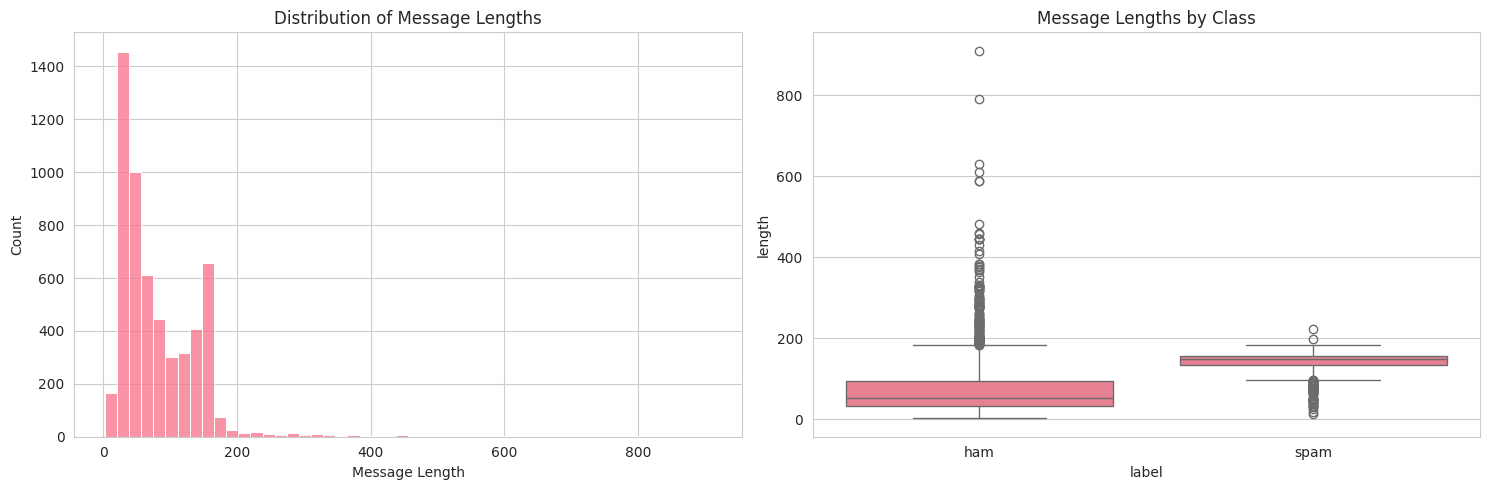


Message length statistics by class:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0


In [6]:
def analyze_message_lengths(df):
    """Analyze and visualize message lengths."""
    df['length'] = df['message'].str.len()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Overall length distribution
    sns.histplot(data=df, x='length', bins=50, ax=ax1)
    ax1.set_title('Distribution of Message Lengths')
    ax1.set_xlabel('Message Length')
    
    # Length distribution by class
    sns.boxplot(data=df, x='label', y='length', ax=ax2)
    ax2.set_title('Message Lengths by Class')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nMessage length statistics by class:")
    print(df.groupby('label')['length'].describe())

analyze_message_lengths(df)

## Text Preprocessing

In [7]:
class TextPreprocessor:
    """Text preprocessing pipeline for SMS messages."""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
    
    def preprocess(self, text):
        """Preprocess a single text message.
        
        Args:
            text (str): Input text message
            
        Returns:
            list: Preprocessed tokens
        """
        # Tokenization
        tokens = word_tokenize(text)
        
        # Convert to lowercase and remove non-alphabetic tokens
        tokens = [token.lower() for token in tokens if token.isalpha()]
        
        # Remove stopwords
        tokens = [token for token in tokens if token not in self.stop_words]
        
        # Lemmatization
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return tokens

# Initialize preprocessor and process messages
preprocessor = TextPreprocessor()
df['processed_message'] = df['message'].apply(preprocessor.preprocess)

# Add token count feature
df['token_count'] = df['processed_message'].apply(len)

# Display example
print("Example preprocessing:")
example_idx = 0
print(f"Original: {df['message'].iloc[example_idx]}")
print(f"Processed: {df['processed_message'].iloc[example_idx]}")

Example preprocessing:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']


## Data Splitting

In [8]:
def prepare_splits(df, train_size=0.7, val_size=0.15, random_state=RANDOM_SEED):
    """Split data into training, validation, and test sets.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        train_size (float): Proportion for training set
        val_size (float): Proportion for validation set
        random_state (int): Random seed for reproducibility
        
    Returns:
        tuple: (train_df, val_df, test_df)
    """
    # First split: separate training set
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        stratify=df['label'],
        random_state=random_state
    )
    
    # Second split: separate validation and test sets
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_size/(1-train_size),
        stratify=temp_df['label'],
        random_state=random_state
    )
    
    print(f"Split sizes: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
    return train_df, val_df, test_df

# Perform splitting
train_df, val_df, test_df = prepare_splits(df)

Split sizes: train=3900, val=835, test=837


## Save Processed Datasets

In [9]:
def save_datasets(train_df, val_df, test_df, output_dir='processed_data'):
    """Save processed datasets to CSV files.
    
    Args:
        train_df (pd.DataFrame): Training data
        val_df (pd.DataFrame): Validation data
        test_df (pd.DataFrame): Test data
        output_dir (str): Output directory
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save datasets
    for name, dataset in [('train', train_df), ('validation', val_df), ('test', test_df)]:
        filepath = os.path.join(output_dir, f'{name}.csv')
        dataset.to_csv(filepath, index=False)
        print(f"Saved {name} dataset to {filepath}")

save_datasets(train_df, val_df, test_df)

Saved train dataset to processed_data/train.csv
Saved validation dataset to processed_data/validation.csv
Saved test dataset to processed_data/test.csv
